<a href="https://colab.research.google.com/github/jmhaussaire/SOAI-Project/blob/master/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTS

In [0]:
%reload_ext autoreload
%autoreload 2
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import os
os.chdir("/gdrive/My Drive/SOAI/")
import glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import scipy.stats
import numpy as np
import copy 


# Get bounding box corners from xml file

In [0]:

all_xml = glob.glob('outputs/*.xml')

tracks = []
ids = []
all_x = []
all_y = []
for x in all_xml:
  root = ET.parse(x).getroot()  
  v_ids = root.findall('object/pose')
  xmin = root.findall('object/bndbox/xmin')
  ymin = root.findall('object/bndbox/ymin')
  for v_id,x,y in zip(v_ids,xmin,ymin):
    all_x.append(float(x.text))
    all_y.append(float(y.text))
    if not v_id.text in ids:
      ids.append(v_id.text)
      track = dict({
          'v_id' : v_id.text,
          'x' : [float(x.text)],
          'y' : [float(y.text)]
      })
      tracks.append(track)
    else:
      for t in tracks[-1:0:-1]:
        if t['v_id'] == v_id.text:
          track = t
      track['x'].append(float(x.text))
      track['y'].append(float(y.text))
  
    

# Plotting 

[{'v_id': '5b60ab3a-87c9-44ec-8bcc-de5a1ccba4e9', 'x': [452.0, 604.0, 953.0, 863.0], 'y': [230.0, 300.0, 358.0, 329.0]}, {'v_id': 'e1c4ede2-c3cb-4fce-81bb-7cab452473af', 'x': [387.0, 583.0, 820.0, 937.0], 'y': [199.0, 256.0, 286.0, 347.0]}, {'v_id': 'ed956f4e-81ae-43d0-a52d-2637b59fb7ec', 'x': [368.0, 637.0, 842.0, 948.0], 'y': [31.0, 125.0, 208.0, 262.0]}, {'v_id': '371abe7e-b9a6-4623-b446-bf145b574d65', 'x': [763.0, 694.0], 'y': [455.0, 453.0]}, {'v_id': '02fab065-ad5b-46cf-8d6f-d60cb430eeba', 'x': [452.0, 615.0, 803.0, 946.0], 'y': [187.0, 255.0, 299.0, 357.0]}, {'v_id': '04eb47a5-6c9e-42c9-b300-0db656c9e8fa', 'x': [362.0, 298.0, 142.0, 2.0], 'y': [367.0, 353.0, 335.0, 325.0]}, {'v_id': 'cbe28e69-9adf-4157-864e-d8027c67746f', 'x': [1343.0], 'y': [501.0]}, {'v_id': 'de47ba55-8afb-4f25-b976-70a37ec226fa', 'x': [1356.0, 1361.0], 'y': [502.0, 504.0]}, {'v_id': 'e9c71d05-5fa7-4ba8-ab23-8ad8b78d8502', 'x': [530.0, 681.0], 'y': [308.0, 335.0]}, {'v_id': '9f8614db-3e12-49e0-9eae-7f73dc4f79e

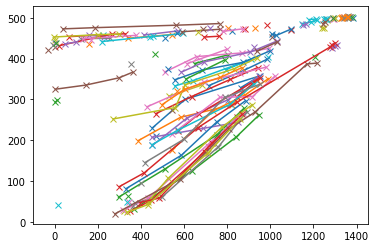

In [0]:
print(tracks)
print(ids)

for t in tracks:
  if t['v_id'] != 'Unspecified':
    plt.plot(t['x'],t['y'],'x-')

# Classification


parameters

In [0]:
n_cluster = 3
max_iter = 100


Functions

In [0]:
def dist_point(point,line):
  """
    Computes the distance square between a point and a line
    inputs:
      - point : (x,y)
      - line  : (slope, intercept)      
  """
   
  return (point[1] - line[0]*point[0]-line[1])**2
  

def dist_track(track,line):
  """ Computes the distance between a track and a line"""
  all_x = track['x']
  all_y = track['y']
  dist = 0
  for x,y in zip(all_x,all_y):
    dist += dist_point((x,y),line)    
  return dist


def compute_mean(tracks):
  all_x = []
  all_y = []
  for t in tracks:
    all_x += t['x']
    all_y += t['y']
  slope,intercept,_,_,_ = scipy.stats.linregress(all_x, all_y)  
  return slope,intercept

def initialization(n_cluster,tracks):
  clusters = []
  for c in range(n_cluster):
    clusters.append(dict({'mean':0,'tracks':[]}))
  for t in tracks:
    clusters[int(np.random.random()*3)]['tracks'].append(t)
  for c in clusters:
    slope,intercept = compute_mean(c['tracks'])
    c['mean'] = (slope,intercept)
  return clusters



Algorithm

In [0]:
clusters = initialization(n_cluster,tracks)

old_clusters = copy.deepcopy(clusters)
#for n in range(n_iter):
n_iter = 0
while True:
  print(n_iter)
  n_iter+=1
  for c in clusters:
    c['tracks'] = []
  for t in tracks:
    min_dist = -1
    for c in clusters:      
      dist = dist_track(t,c['mean'])
      if dist<min_dist or min_dist<0:
        min_dist = dist
        cluster = c
    cluster['tracks'].append(t)
  for c in clusters:
    slope,intercept = compute_mean(c['tracks'])
    c['mean'] = (slope,intercept)
    
  if clusters == old_clusters:
    break
  else:
    old_clusters = copy.deepcopy(clusters)
  if n_iter > max_iter:
    break
    


0
1
2
3
4


plotting result

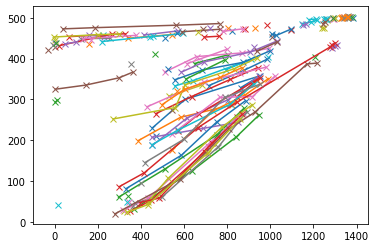

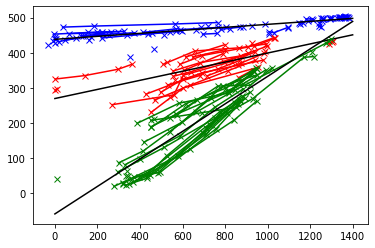

In [0]:
for t in tracks:
  if t['v_id'] != 'Unspecified':
    plt.plot(t['x'],t['y'],'x-')
plt.figure()
for c,color in zip(clusters,['b','r','g']):
  for t in c['tracks']:
    plt.plot(t['x'],t['y'],'x-',color=color)
  x_mean = list(range(0,1400))
  y_mean = c['mean'][0]*np.array(x_mean) + c['mean'][1]
  
  plt.plot(x_mean,y_mean,color='k')
